# Tumoroscope in PyMC

[![python](https://img.shields.io/badge/Python-3.10-3776AB.svg?style=flat&logo=python&logoColor=white)](https://www.python.org)
[![Code style: black](https://img.shields.io/badge/code%20style-black-000000.svg)](https://github.com/psf/black)
[![pre-commit](https://img.shields.io/badge/pre--commit-enabled-brightgreen?logo=pre-commit&logoColor=white)](https://github.com/pre-commit/pre-commit)
[![Checked with mypy](http://www.mypy-lang.org/static/mypy_badge.svg)](http://mypy-lang.org/)
[![pydocstyle](https://img.shields.io/badge/pydocstyle-enabled-AD4CD3)](http://www.pydocstyle.org/en/stable/)
[![License: GPLv3](https://img.shields.io/badge/License-GPLv3-blue.svg)](https://www.gnu.org/licenses/gpl-3.0)

**WIP**

This package builds the ['Tumoroscope']() (Shafighi *et al.*, 2022, bioRxiv preprint) model with the probabilistic programming library [PyMC]().
'Tumoroscope' is a "probabilistic model that accurately infers cancer clones and their high-resolution localization by integrating pathological images, whole exome sequencing, and spatial transcriptomics data."

![Tumoroscope diagram](tumoroscope-diagram.jpeg)

## Installation

> As this package provides a model produced using PyMC, I recommend first creating a virtual environment using `conda` and installing the PyMC library.
> You can follow their instructions [here](https://www.pymc.io/projects/docs/en/latest/installation.html).

You can install this package using `pip` either from PyPI

```bash
pip install tumoroscope-pymc  # not available yet
```

or from GitHub

```
pip install git+https://github.com/jhrcook/tumoroscope-pymc.git
```

## Use

(TODO)

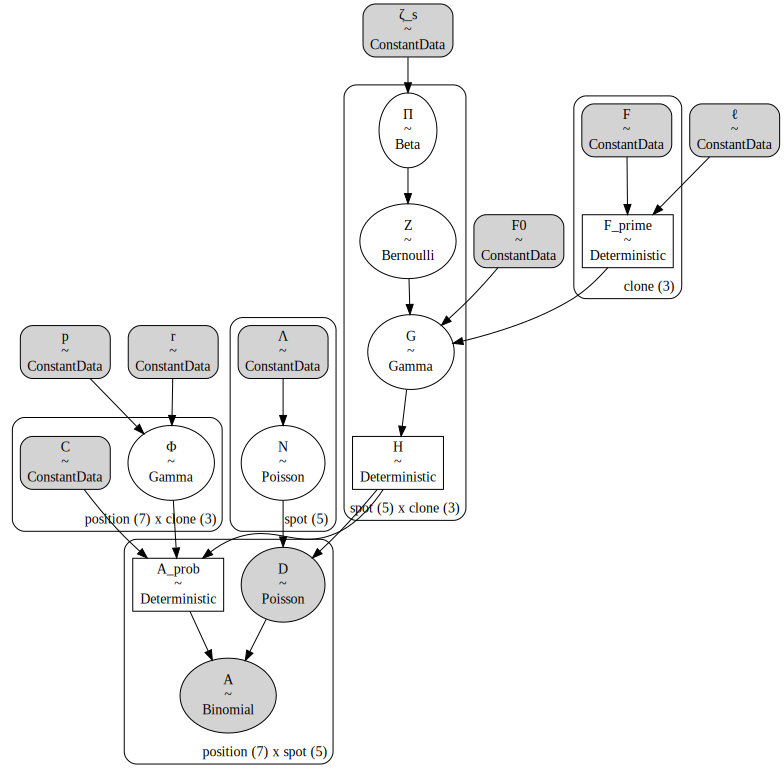

In [1]:
import numpy as np
import pymc as pm

from tumoroscope import build_tumoroscope_model, TumoroscopeData
from tumoroscope.mock_data import generate_random_data

np.random.seed(1)
data = generate_random_data()

model = build_tumoroscope_model(data)
pm.model_to_graphviz(model)

---

## Environment information


In [2]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2022-10-23

Python implementation: CPython
Python version       : 3.10.6
IPython version      : 8.5.0

Compiler    : Clang 13.0.1 
OS          : Darwin
Release     : 21.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit

Hostname: JHCookMac.local

Git branch: dev

numpy: 1.23.4
pymc : 4.2.2

